In [1]:
import numpy as np
data_path = "/Users/waelbenslima/Desktop/data/phione1.txt"
data = np.loadtxt(data_path)
data_reshaped = data.reshape((1331, 171, 171))
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data
phi2 = data_reshaped1.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi2)
phi1 = data_reshaped.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi1)

# Normalize data
phi2_norm = phi2 / np.max(phi2)
phi1_norm = phi1 / np.max(phi1)

# Define function to generate random masks with sparsity
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Define function to add noise
def add_noise(data, sigma):
    # Add noise: (1 + u(0, sigma)) * data
    noise = np.random.normal(0, sigma, data.shape)
    noisy_data = data * (1 + noise)
    return noisy_data

# Apply masks to phi2 data
sparsity = 0.8
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Add noise with different sigma values
sigma_values = [0.01, 0.2, 0.5]
noisy_phi2 = {}

for sigma in sigma_values:
    print(f"Adding noise with sigma = {sigma}")
    noisy_phi2[sigma] = add_noise(phi2_masked, sigma)

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi1_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Adding noise with sigma = 0.01
Adding noise with sigma = 0.2
Adding noise with sigma = 0.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ phi2_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 171, 171,  │          0 │ phi2_input[0][0], │
│ (Multiply)          │ 1)                │            │ mask_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 171, 171,  │        320 │ multiply_1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 86, 86,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 86, 86,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 43, 43,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 43, 43,    │     36,928 │ max_pooling2d_3[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 86, 86,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 86, 86,    │     18,464 │ up_sampling2d_2[… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 172, 172,  │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 172, 172,  │        289 │ up_sampling2d_3[… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d_1        │ (None, 171, 171,  │          0 │ conv2d_5[0][0]    │
│ (Cropping2D)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

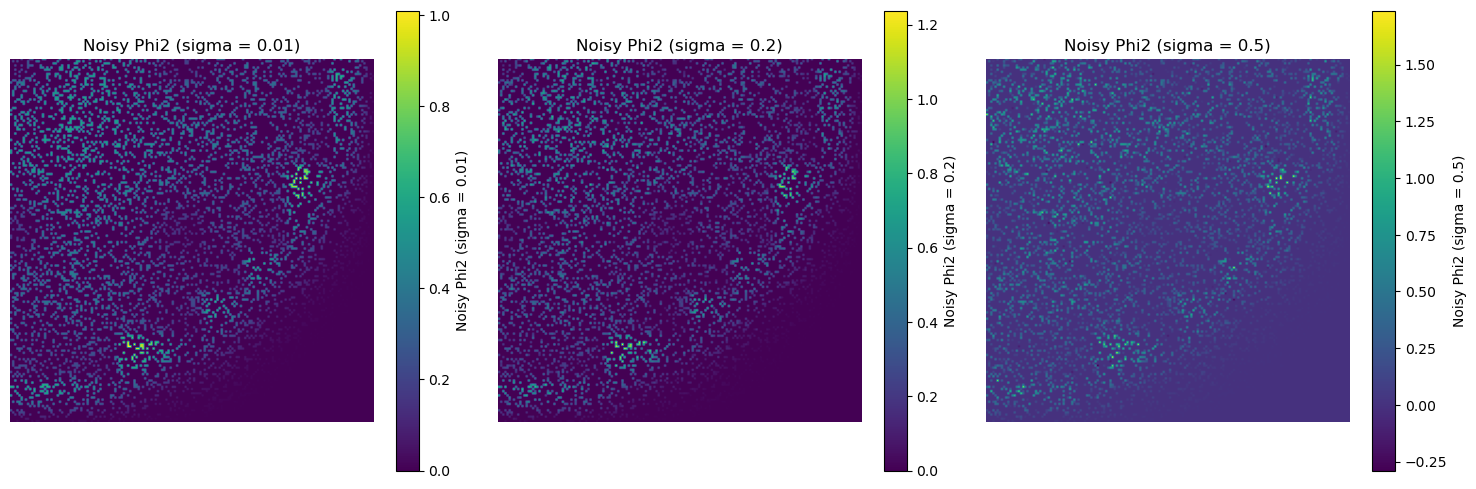

In [9]:
# Visualize noisy phi2 data for different sigma values

n_samples = 3  # Number of samples to display

# Create subplots for noisy Phi2 for different sigma values
plt.figure(figsize=(15, 5))

for i, sigma in enumerate(sigma_values):
    plt.subplot(1, len(sigma_values), i + 1)
    plt.imshow(noisy_phi2[sigma][0].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label=f'Noisy Phi2 (sigma = {sigma})')
    plt.title(f'Noisy Phi2 (sigma = {sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 608ms/step - loss: 0.0792 - val_loss: 0.0187
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 798ms/step - loss: 0.0167 - val_loss: 0.0121
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 801ms/step - loss: 0.0116 - val_loss: 0.0077
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 888ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 824ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 649ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 744ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 811ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 757ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 745ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27

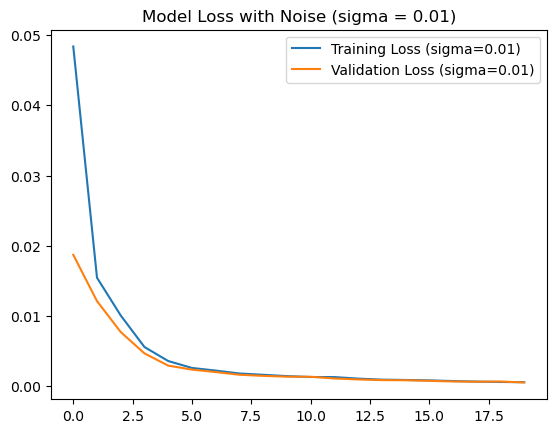

In [11]:
# Add noise with sigma = 0.01 to phi2 data
sigma = 0.01
noisy_phi2_001 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_001, X_test_001, y_train_001, y_test_001, masks_train_001, masks_test_001 = train_test_split(
    noisy_phi2_001, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_001 = model.fit(
    [X_train_001, masks_train_001], y_train_001,
    validation_data=([X_test_001, masks_test_001], y_test_001),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_001.history['loss'], label='Training Loss (sigma=0.01)')
plt.plot(history_001.history['val_loss'], label='Validation Loss (sigma=0.01)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.01)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


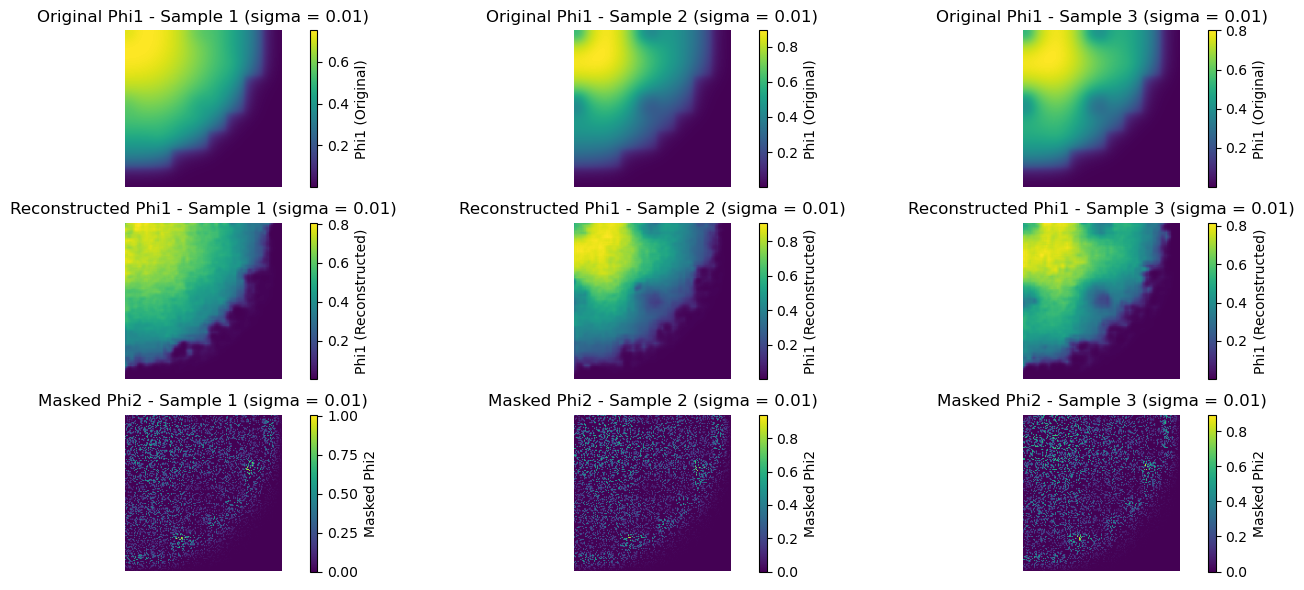

In [13]:
# Predict the output for the noisy input (sigma = 0.01)
predicted_phi1_001 = model.predict([X_test_001, masks_test_001])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sigma = 0.01)
predicted_phi1_001 = model.predict([X_test_001, masks_test_001])

# Flatten the images for metric calculations
y_true_flat = y_test_001.flatten()
y_pred_flat = predicted_phi1_001.flatten()

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test_001[0].reshape(171, 171), predicted_phi1_001[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.01
print(f"Sigma = 0.01:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Sigma = 0.01:
RMSE: 0.023320854511611963
L∞ Error: 0.524360402736676
SSIM: 0.8863642094031039
L2 Error: 65.16226934486137
Relative L2 Error: 5.48%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 737ms/step - loss: 0.0011 - val_loss: 9.2314e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 666ms/step - loss: 9.3271e-04 - val_loss: 8.5533e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - loss: 8.6343e-04 - val_loss: 8.4253e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 867ms/step - loss: 8.7006e-04 - val_loss: 8.0780e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 581ms/step - loss: 7.7899e-04 - val_loss: 7.3077e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 566ms/step - loss: 7.4659e-04 - val_loss: 7.5007e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step - loss: 7.0877e-04 - val_loss: 6.9088e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 576ms/step - loss: 7.0521e-04 - val_loss: 6.5655e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 6.8859e-04 - val_loss: 6.9919e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 7.0108e-04 - val_loss: 6.3613e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step

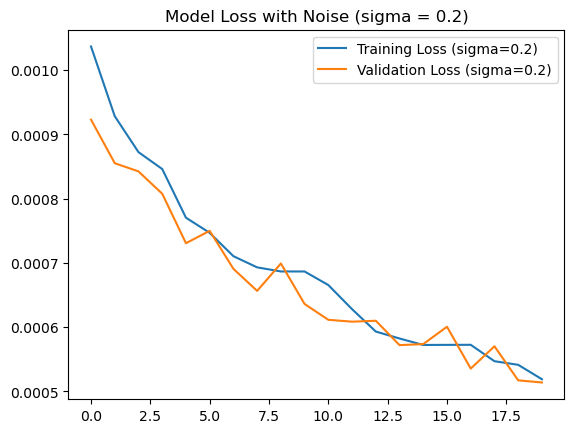

In [19]:
# Add noise with sigma = 0.2 to phi2 data
sigma = 0.2
noisy_phi2_002 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_002, X_test_002, y_train_002, y_test_002, masks_train_002, masks_test_002 = train_test_split(
    noisy_phi2_002, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_002 = model.fit(
    [X_train_002, masks_train_002], y_train_002,
    validation_data=([X_test_002, masks_test_002], y_test_002),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_002.history['loss'], label='Training Loss (sigma=0.2)')
plt.plot(history_002.history['val_loss'], label='Validation Loss (sigma=0.2)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.2)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


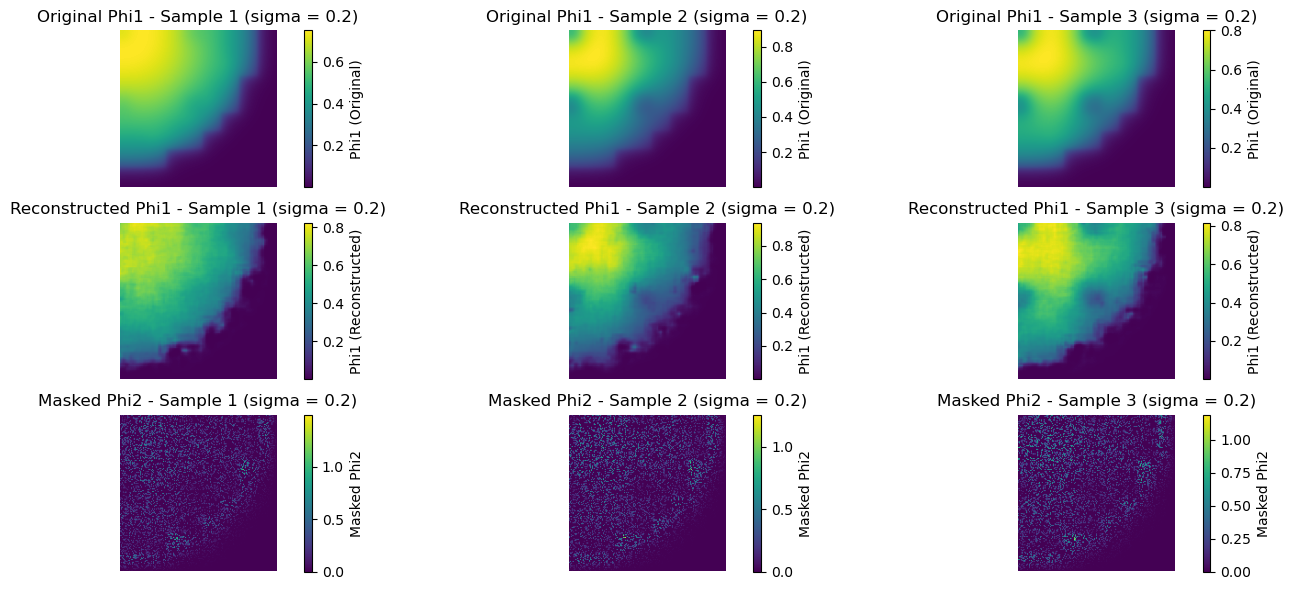

In [21]:
# Predict the output for the noisy input (sigma = 0.2)
predicted_phi1_002 = model.predict([X_test_002, masks_test_002])

# Visualize results
n_samples = 3
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [23]:
# Predict the output for the noisy input (sigma = 0.2)
predicted_phi1_002 = model.predict([X_test_002, masks_test_002])

# Flatten the images for metric calculations
y_true_flat_002 = y_test_002.flatten()
y_pred_flat_002 = predicted_phi1_002.flatten()

# 1. Calculate RMSE (Root Mean Squared Error)
rmse_002 = np.sqrt(mean_squared_error(y_true_flat_002, y_pred_flat_002))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error_002 = np.max(np.abs(y_true_flat_002 - y_pred_flat_002))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index_002 = ssim(y_test_002[0].reshape(171, 171), predicted_phi1_002[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error_002 = np.linalg.norm(y_true_flat_002 - y_pred_flat_002)

# 5. Calculate Relative L2 Error
true_l2_norm_002 = np.linalg.norm(y_true_flat_002)
relative_l2_error_002 = (l2_error_002 / true_l2_norm_002) * 100  # Convert to percentage

# Print the results for sigma = 0.2
print(f"Sigma = 0.2:")
print(f"RMSE: {rmse_002}")
print(f"L∞ Error: {l_inf_error_002}")
print(f"SSIM: {ssim_index_002}")
print(f"L2 Error: {l2_error_002}")
print(f"Relative L2 Error: {relative_l2_error_002:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Sigma = 0.2:
RMSE: 0.02267097857242231
L∞ Error: 0.7542572968091128
SSIM: 0.8817023224387515
L2 Error: 63.34641002593767
Relative L2 Error: 5.32%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 826ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 783ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 646ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 588ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 746ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 638ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 700ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 665ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22

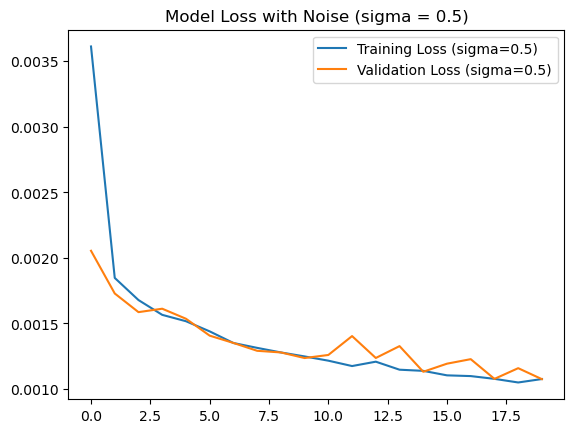

In [25]:
# Add noise with sigma = 0.5 to phi2 data
sigma = 0.5
noisy_phi2_005 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_005, X_test_005, y_train_005, y_test_005, masks_train_005, masks_test_005 = train_test_split(
    noisy_phi2_005, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_005 = model.fit(
    [X_train_005, masks_train_005], y_train_005,
    validation_data=([X_test_005, masks_test_005], y_test_005),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_005.history['loss'], label='Training Loss (sigma=0.5)')
plt.plot(history_005.history['val_loss'], label='Validation Loss (sigma=0.5)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.5)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


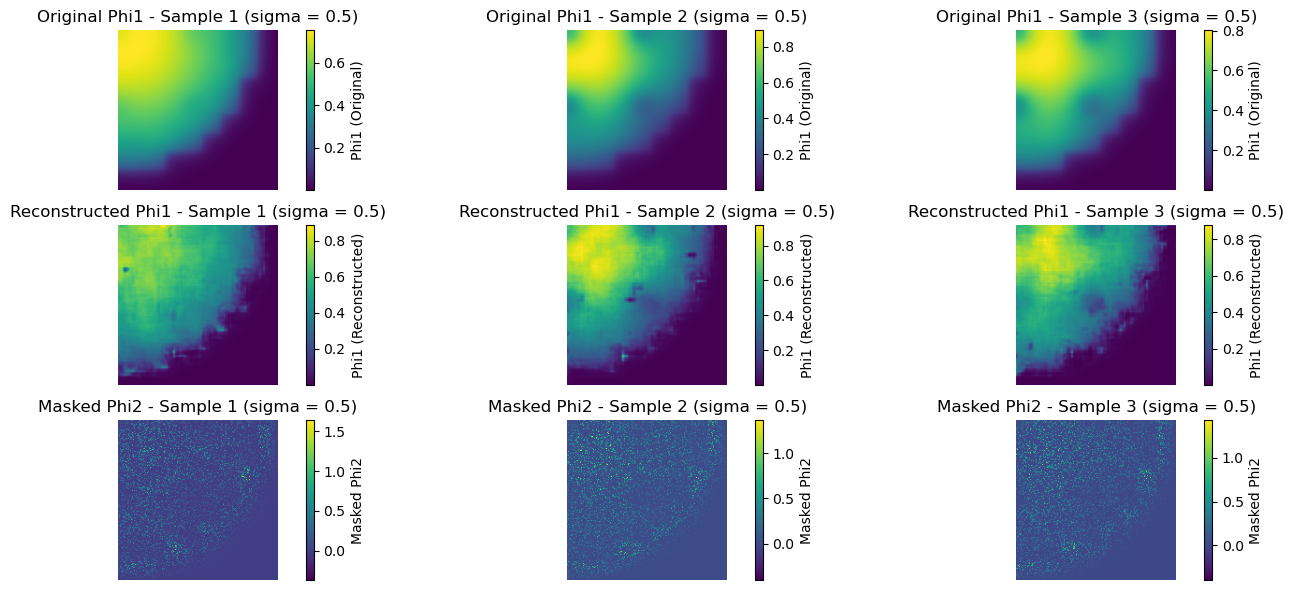

In [27]:
# Predict the output for the noisy input (sigma = 0.5)
predicted_phi1_005 = model.predict([X_test_005, masks_test_005])

# Visualize results
n_samples = 3
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
# Predict the output for the noisy input (sigma = 0.5)
predicted_phi1_005 = model.predict([X_test_005, masks_test_005])

# Flatten the images for metric calculations
y_true_flat_005 = y_test_005.flatten()
y_pred_flat_005 = predicted_phi1_005.flatten()

# 1. Calculate RMSE (Root Mean Squared Error)
rmse_005 = np.sqrt(mean_squared_error(y_true_flat_005, y_pred_flat_005))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error_005 = np.max(np.abs(y_true_flat_005 - y_pred_flat_005))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index_005 = ssim(y_test_005[0].reshape(171, 171), predicted_phi1_005[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error_005 = np.linalg.norm(y_true_flat_005 - y_pred_flat_005)

# 5. Calculate Relative L2 Error
true_l2_norm_005 = np.linalg.norm(y_true_flat_005)
relative_l2_error_005 = (l2_error_005 / true_l2_norm_005) * 100  # Convert to percentage

# Print the results for sigma = 0.5
print(f"Sigma = 0.5:")
print(f"RMSE: {rmse_005}")
print(f"L∞ Error: {l_inf_error_005}")
print(f"SSIM: {ssim_index_005}")
print(f"L2 Error: {l2_error_005}")
print(f"Relative L2 Error: {relative_l2_error_005:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Sigma = 0.5:
RMSE: 0.03278516695426262
L∞ Error: 0.7797494285191653
SSIM: 0.8434254734221039
L2 Error: 91.60710121175734
Relative L2 Error: 7.70%
--------------------------------------------------
